In [1]:
import json
routes = json.loads(open('/home/student/db/resources/trimmed_routes.json','r').read())

In [2]:
for v in routes['15']:
    print (v[0])

 Hawkins St
 Ballycullen Road
 Clongriffin
 Eden Quay


In [3]:
#we will use the route to clongriffin as this is the longest one

In [3]:
from dbanalysis import stop_tools
import pandas as pd
class BRModel():
    """
    Big route model class
    uses the distance of a stop from first stop on a route to compute predictions lalalala
    MAPE and r2 scores are not as good as they were in the notebook
    (we achieved 0.57 r2, and 7% MAPE on the time to complete the route)
    Should look into this.
    """
    def __init__ (self, route,variation,verbose=True,src='build',rgr='RandomForest',\
                mode='validate',features = ['base_time_dep','distance','rain','temp','day'],use_dummies=True):
        
        import json
        self.regr_type = rgr
        self.verbose = verbose
        self.route = route
        self.use_dummies = use_dummies
        self.variation = variation
        self.routes = json.loads(open('/home/student/dbanalysis/dbanalysis/resources/trimmed_routes.json').read())
        self.features = features
        self.route_array = self.routes[route][variation][1:]
        del(self.routes)
        if src == 'build':
            if not self.can_be_modelled():
                
                raise ValueError ('Missing data for modelling this route')

            self.gather_data()
            self.preprocess()
            if rgr == 'RandomForest':
                from sklearn.ensemble import RandomForestRegressor as rf
                self.rgr = rf()
            elif rgr == 'Linear':
                from sklearn.linear_model import LinearRegression as lr
                self.rgr = lr(fit_intercept=True)
            elif rgr == 'Neural':
                from sklearn.neural_network import MLPRegressor as mlpr
                self.rgr = mlpr(hidden_layer_sizes=(100,),verbose=True)
                from sklearn.preprocessing import normalize
                
 
            #if mode == 'validate':
            #   if self.regr_type == 'Neural':
                    #self.validate_neural()
            #   else:
                    #self.validate_model()
            #lif mode == 'production':
                #self.build_full_model()
                #self.dump_model()
    def validate_neural(self):
        print('training regressor')
        self.model = self.rgr.fit(self.train_X,self.train_Y)
        preds = self.model.predict(self.test_1_X)
        from sklearn import metrics
        print('Validating...')
        print(metrics.r2_score(self.test_1_Y,preds))
        preds = self.model.predict(self.test_2_X)
        print(metrics.r2_score(self.test_2_Y,preds))
        print('calculated from norms-->')
        preds = preds * self.test_2_norm
        print(metrics.r2_score(self.test_2_real,preds))
        preds = self.model.predict(self.test_3_X)
        print(metrics.r2_score(self.test_3_Y,preds))
    def validate_model(self):
        self.data = self.data[self.data['traveltime']>0] 
        if self.verbose:
            print('Validating model on all trips...\n\n')
        
        self.train = self.data[self.data['year']==2016]
        self.test = self.data[self.data['year']==2017]
        self.model = self.rgr.fit(self.train_X,self.train_Y)
        preds = self.model.predict(self.test_1_X)
        from sklearn import metrics
        print('-----> Tested on all distances')
        print('R2:', metrics.r2_score(self.test_1_Y,preds))
        print('MAE:', metrics.mean_absolute_error(self.test_1_Y,preds)*self.norm[-1])
        print('MAPE:', ((abs(self.test_1_Y-preds)/self.test_1_Y)*100).mean())
        #add more options for testing eventually
        print('Validating model on longest trip')
        test2= self.test[self.test['distance']==self.test['distance'].max()]
        if self.regr_type == 'Neural':
            test2 = self.test[self.test['distance2']==self.test['distance2'].max()]
        preds = self.model.predict(test2[self.features])
        print('-----> ')
        print('R2:', metrics.r2_score(test2['traveltime'],preds))
        print('MAE:', metrics.mean_absolute_error(test2['traveltime'],preds)*self.norm[-1])
        print('MAPE:', ((abs(test2['traveltime']-preds)/test2['traveltime'])*100).mean())
        print('\n\n Validated on median trip -->')
        test2= self.test[self.test['distance']==self.test['distance'].median()]
        if self.regr_type == 'Neural':
            test2 = self.test[self.test['distance2']==self.test['distance2'].median()]
        
        preds = self.model.predict(test2[self.features])
        print('-----> ')
        print('R2:', metrics.r2_score(test2['traveltime'],preds))
        print('MAE:', metrics.mean_absolute_error(test2['traveltime'],preds)*self.norm[-1])
        print('MAPE:', ((abs(test2['traveltime']-preds)/test2['traveltime'])*100).mean())
        del(self.train)
        del(self.test)
        del(self.data)
        del(test2)


    def gather_data(self):
        if self.verbose:
            print('gathering data...')
        from dbanalysis import stop_tools
        arr = self.route_array
        import os
        to_concat = []
        for i in range(len(arr)-1):
            
            data = stop_tools.get_stop_link(arr[i],arr[i+1])
            to_concat.append(data)
            del(data)
        self.data = pd.concat(to_concat,axis=0)
        del to_concat
        

    def preprocess(self):
        if self.verbose:
            print('Preprocessing data')
        self.select_routes()
        self.clean_1()
        self.add_distances()
        self.add_base_departure_time()
        self.add_time_info()
        
        self.merge_weather()
        #if self.use_dummies:
        #    self.add_dummies()
        #    self.features += self.dummy_features
    def select_routes(self):
        if self.verbose:
            print('parsing routeids')
        routeids = self.data['routeid'].unique()
        valid_routeids = [r for r in routeids if r.split('_')[0] == self.route]
        self.data = self.data[self.data['routeid'].isin(valid_routeids)]
    def clean_1(self):
        if self.verbose:
            print('dropping null values')
        self.data = self.data.dropna()
        
    def add_distances(self):
        if self.verbose:
            print('adding distances')
        s_getter =stop_tools.stop_getter()
        total_distance = 0
        r = self.route_array
        route_distances = {r[0]:0}
        
        for i in range(0, len(r)-1):
            distance = s_getter.get_stop_distance(str(r[i]),str(r[i+1]))
                
            total_distance += distance
            route_distances[r[i+1]]=total_distance
        self.data['distance']=self.data['stopA'].apply(lambda x: route_distances[x])
        del(s_getter)
    def add_base_departure_time(self):
        if self.verbose:
            print('adding base departure times')
       
        keys= self.data[self.data['stopA']==self.route_array[0]]
        keys['base_time_dep']=keys['actualtime_arr_from']
        keys2=keys[['tripid','dayofservice','routeid','base_time_dep']]
        self.data = pd.merge(self.data,keys2,on=['dayofservice','tripid','routeid'])
        
        self.data['traveltime']=self.data['actualtime_arr_from']-self.data['base_time_dep'] 
        #A number of rows have negative travel time. But its a really small number, so I guess they 
        #can go in the bin.
        self.data = self.data[self.data['traveltime']>0]
        del(keys)
        del(keys2)
    
    def add_time_info(self):
        if self.verbose:
            print('adding time information')
        time_format = "%d-%b-%y %H:%M:%S"
        self.data['dt']=pd.to_datetime(self.data['dayofservice'],format=time_format)
        self.data['day']=self.data['dt'].dt.dayofweek
        self.data['month']=self.data['dt'].dt.month
        self.data['hour'] = self.data['dt'].dt.hour
        self.data['weekend']=self.data['day']>4
        self.data['year']=self.data['dt'].dt.year
        self.data['date'] = self.data['dt'].dt.date
    def merge_weather(self,weather=None):
        if self.verbose:
            print('merging weather')
        if weather == None:
          
            weather = pd.read_csv('/home/student/dbanalysis/dbanalysis/resources/cleanweather.csv').dropna()
        weather['dt']=pd.to_datetime(weather['date'])
        weather['hour']=weather['dt'].dt.hour
        weather['date']=weather['dt'].dt.date
        
        self.data = pd.merge(self.data,weather,on=['date','hour'])
        del(weather)

    def add_dummies(self):
        if self.verbose:
            print('Making dummy features')
        self.data = pd.get_dummies(self.data,columns=['day','month','hour'])
        self.dummy_features = [col for col in self.data.columns\
                                if (col[0:3] == 'day' and col != 'dayofservice')\
                                or col[0:5] == 'month' or col[0:4] == 'hour']


    def can_be_modelled(self):
        if self.verbose:
            print('Checking for data files')
        import os
        base_dir = '/data/stops/'
        arr = self.route_array
        for i in range(len(arr)-1):
            
            if os.path.exists(base_dir+str(arr[i])+'/'+str(arr[i+1])+'.csv'):
                pass
            else:
                print('broken')
                input()
                return False
        return True


In [4]:
r = BRModel('15',1,rgr='Neural')

Checking for data files
gathering data...
Preprocessing data
parsing routeids
dropping null values
adding distances
adding base departure times


/home/student/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


adding time information
merging weather


In [5]:
train = r.data[r.data['year']==2016]
test = r.data[r.data['year']==2017]

In [6]:
from sklearn.preprocessing import StandardScaler as ss

In [7]:
scaler_X = ss()
X = scaler_X.fit_transform(train[r.features])

In [8]:
scaler_Y = ss()
Y = scaler_Y.fit_transform(train['traveltime'].values.reshape(-1,1))

/home/student/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [9]:
model = r.rgr.fit(X,Y)

/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:1306: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.03056462
Iteration 2, loss = 0.02082174
Iteration 3, loss = 0.01918125
Iteration 4, loss = 0.01868848
Iteration 5, loss = 0.01844031
Iteration 6, loss = 0.01825141
Iteration 7, loss = 0.01814995
Iteration 8, loss = 0.01807673
Iteration 9, loss = 0.01798969
Iteration 10, loss = 0.01789778
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.


# Test on training set

In [10]:
preds = scaler_Y.inverse_transform(model.predict(X))
((abs(train['traveltime']-preds)/train['traveltime'])*100).mean()

16.580442286452428

# Test on test set

In [16]:
from sklearn import metrics
real_Y = test['traveltime']
X = scaler_X.transform(test[r.features])
preds = scaler_Y.inverse_transform(model.predict(X))
print(((abs(real_Y-preds)/real_Y)*100).mean())
print(metrics.r2_score(real_Y,preds))

17.52574523005161
0.9606623172480844


In [17]:
distances = sorted(test['distance'].unique())
ds = []
r2 = []
mape = []
for i in range(0,len(distances)-1):
    distance1 = distances[i]
    distance2 = distances[i+1]
    X = test[(test['distance']>=distance1) & (test['distance'] < distance2)]
    real_Y = X['traveltime']
    X = scaler_X.transform(X[r.features])
    preds =  scaler_Y.inverse_transform(model.predict(X))
    ds.append(distance1)
    from sklearn import metrics
    r2.append(metrics.r2_score(real_Y,preds))
    mape.append(((abs(real_Y - preds)/real_Y)*100).mean())
    print(preds.min())
    
    


-669.2571472391214
-622.6888569643393
-524.9539256369553
-282.871276413794
-281.13957123492264
-5.7831554605454585
53.06836666861318
-114.59779030905929
-37.235166706325344
44.416010057432686
289.02907578442864
325.42144077868033
186.1347802471155
389.5930470397054
411.8906099100691
273.6898225182872
325.0450942494522
370.55693955706283
418.9616842503069
467.81965585749003
509.6905096805426
550.1995176123205
603.7496216201359
650.0231062121632
702.5657467351302
745.4774082468043
775.3315367558127
800.2682931736961
826.5549296742431
845.2673380050903
889.1260087097291
1415.4239262247397
1325.8879511056018
1291.258411733448
1380.570329469062
1493.466691820258
1612.230709285209
1681.3676458468976
1709.0982374536964
1739.7797199213182
1757.8135959488623
1781.2677830545335
1814.4303412226373
1844.3021173571794
1882.576873181907
1923.0749735120276
1948.8611397200525
1983.4031666981832
2007.8596505640414
2030.0888265202848
2069.738277023419
2101.2218986584276
2123.22361470927
2143.07037419400

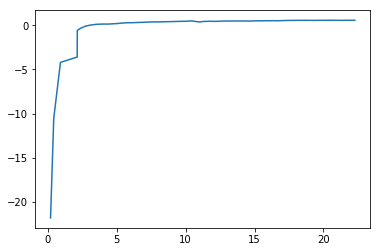

In [18]:
from matplotlib import pyplot as plt
plt.plot(ds,r2)
plt.show()

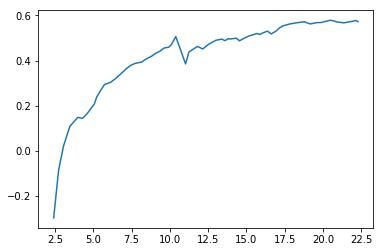

In [19]:
from matplotlib import pyplot as plt
plt.plot(ds[5:],r2[5:])
plt.show()

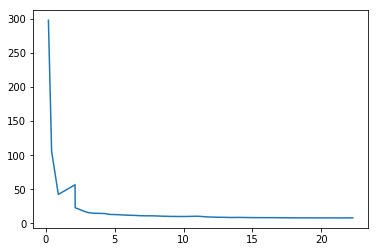

In [20]:
plt.plot(ds,mape)
